<h1 style="color:#3a7aad">War on Arrhythmia 2.0</h1>

Application of Machine Learning Techniques on the Early Detection of a Heart Arrhythmia

By Ahmad Chaiban

<h2 style="color:#3a7aad">Preliminary Data Exploration</h2>

In [1]:
import wfdb
from glob import glob
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt 

from preprocessor import *

tqdm.pandas()

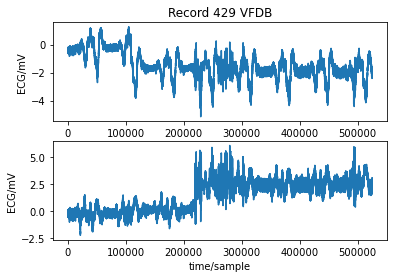

{'record_name': '429', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 525000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['ECG', 'ECG'], 'p_signal': array([[-0.3  , -0.09 ],
       [-0.32 , -0.08 ],
       [-0.315, -0.11 ],
       ...,
       [-1.98 ,  2.6  ],
       [-1.945,  2.625],
       [-1.935,  2.625]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['429.dat', '429.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-60, -18], 'checksum': [13954, -29553], 'block_size': [0, 0]}


In [2]:
record = wfdb.rdrecord('./Data_thesis/VFDB/429')
wfdb.plot_wfdb(record=record, title='Record 429 VFDB')
print(record.__dict__)

In [3]:
sample_record = record.p_signal
sample_record[:10]

array([[-0.3  , -0.09 ],
       [-0.32 , -0.08 ],
       [-0.315, -0.11 ],
       [-0.345, -0.09 ],
       [-0.335, -0.1  ],
       [-0.335, -0.1  ],
       [-0.31 , -0.09 ],
       [-0.315, -0.09 ],
       [-0.305, -0.07 ],
       [-0.325, -0.075]])

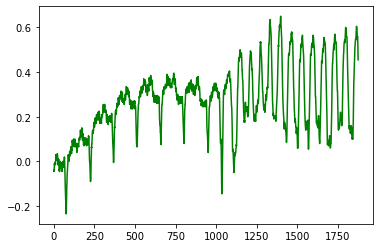

In [4]:

plt.plot(sample_record[:, 0][99624:101499], color='green')

In [5]:
annotation = wfdb.rdann('./Data_thesis/VFDB/418', extension='atr')
annotation.__dict__

{'record_name': '418',
 'extension': 'atr',
 'sample': array([    18,  99624, 101499, 133092, 134038, 135775, 136628, 153057,
        154115, 154942, 156291, 159442, 160516, 169192, 169807, 173054,
        173673, 174788, 175403, 176259, 177868, 190080, 191249, 191807,
        192695, 195631, 196794, 200211, 200634, 216788, 219038, 219961,
        224019, 225355, 226057, 227211, 229269, 231310, 232724, 234499,
        235538, 254230, 255365, 256019, 256884, 257249, 257980, 259557,
        261903, 262749, 263519, 269307, 270999, 271326, 271596, 272057,
        272384, 273673, 275846, 279576, 281384, 289384, 291211, 300480,
        301076, 301525, 301711, 302230, 302538, 302871, 303346, 303641,
        304634, 311442, 311807, 312096, 313480, 313826, 314173, 314493,
        316807, 317237, 317480, 318682, 319769, 327480, 329038, 329365,
        329749, 333826, 334211, 339769, 340019, 346634, 347038, 347403,
        347730, 357634, 358403, 362711, 363115, 367749, 368134, 368583,
        36

<h2 style="color:#3a7aad">Label Separation and Building the initial record database</h2>

Separating the VF, VT and Normal Episodes per record for the all three databases

In [6]:
def split_record_per_label(record, annotation):
    sample_indexes = annotation.sample
    signal_divided, labels_divided = [], []
    for i in range(len(annotation.sample)-1):
        signal_section = record.p_signal[sample_indexes[i]:sample_indexes[i+1]].tolist()
        signal_divided.append(signal_section)
        labels_divided.append(annotation.aux_note[i])
    signal_divided.append(record.p_signal[sample_indexes[-1]:-1].tolist())
    labels_divided.append(annotation.aux_note[-1])
    return signal_divided, labels_divided


def split_all_records(paths):
    record_db = {}
    for path in paths:
        record = wfdb.rdrecord(path)
        annotation = wfdb.rdann(path, extension='atr')
        signal_divided, labels_divided = split_record_per_label(record, annotation)
        record_db[annotation.record_name] = {'signal': signal_divided, 'label': labels_divided}
    return record_db

In [7]:
signal_divided, labels_divided = split_record_per_label(record, annotation)

In [8]:
paths = [path.replace('.dat', '') for path in glob('./Data_thesis/*/*.dat')]
record_db = split_all_records(paths)

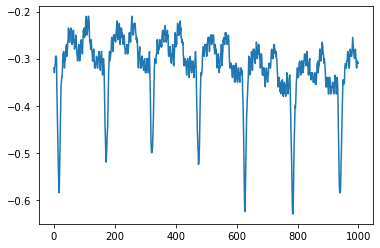

In [9]:
plt.plot([i[0] for i in signal_divided[0]][:1000])

In [10]:
labels_divided[0]

'(N\x00'

In [11]:
record_db.keys()

dict_keys(['429', '602', '428', '614', '615', '611', '605', '610', '612', '607', '420', '421', '423', '609', '422', '426', '427', '419', '425', '430', '424', '418', 'cu23', 'cu22', 'cu08', 'cu34', 'cu20', 'cu21', 'cu35', 'cu09', 'cu31', 'cu25', 'cu19', 'cu18', 'cu24', 'cu30', 'cu26', 'cu32', 'cu33', 'cu27', 'cu02', 'cu16', 'cu17', 'cu03', 'cu29', 'cu15', 'cu01', 'cu14', 'cu28', 'cu10', 'cu04', 'cu05', 'cu11', 'cu07', 'cu13', 'cu12', 'cu06', '213', '207', '212', '210', '205', '201', '215', '214', '200', '228', '202', '203', '217', '106', '112', '113', '107', '111', '105', '104', '114', '100', '101', '115', '103', '117', '116', '102', '124', '118', '119', '109', '121', '108', '122', '123', '232', '233', '231', '219', '230', '208', '220', '234', '221', '209', '223', '222'])

<h2 style="color:#3a7aad">Saving Unprocessed Record Data</h2>

In [12]:
# import json

# with open('record_data.json', 'w') as fp:
#     json.dump(record_db, fp)

<h2 style="color:#3a7aad">Signal Preprocessing</h2>

<h3 style="color:#3a7aad">Checking for Null Values</h3>

In [13]:
# for key in record_db.keys():
#     nulls = np.isnan(record_db[key]['signal'][0])
#     for i in range(len(nulls)):
#         if nulls[i][0] is True:
#             print(f'Found Null Value at index {i}')

<h3 style="color:#3a7aad">Preprocessing</h3>

In [15]:
def prod(val) : 
    res = 1 
    for ele in val: 
        res *= ele 
    return res  


def signal_preprocessor(data):
    """
    1. Normalization
    2. Moving Average Filter
    3. Butterworth high pass filter
    4. Butterworth low pass filter
    5. Frequency resampling
    """
    mean = np.mean(data)
    data = data - mean

    data = moving_average(data, 5)
    data = np.array(data)

    data = butter_highpass_filter(data, 1, 250, 5)

    signal = butter_lowpass_filter(data, 1, 30, 5)
    
    fs = 360
    time = np.arange(signal.size)/fs

    return signal, time


def preprocess_record_db(record_db_copy):
    """
    Only processing the first channel for now
    """
    for key in tqdm(record_db_copy.keys()):
        prepped_signals = []
        for i in range(len(record_db_copy[key]['signal'])):
            two_channel_signal = record_db_copy[key]['signal'][i]
            channel_1 = np.array(two_channel_signal)[:, 0].flatten()
            prepped_channel_1, time = signal_preprocessor(channel_1)
            prepped_signals.append([prepped_channel_1, time])
            record_db_copy[key]['signal'][i] = prepped_signals
    return record_db_copy

preped_record_db = preprocess_record_db(record_db)

  0%|          | 0/105 [00:00<?, ?it/s]/var/folders/z0/cl32n6v93vs8__dh_2nx_0j00000gn/T/ipykernel_7721/4184907853.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  channel_1 = np.array(two_channel_signal)[:, 0].flatten()
  0%|          | 0/105 [00:00<?, ?it/s]

23


ValueError: operands could not be broadcast together with shapes (100593,) (1500,) 

In [ ]:
preped_record_db.keys()